In [1]:
import json
import numpy as np
import pandas as pd

import sys
sys.path.append('../../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, export_StochSS
from gillespy2 import ODECSolver, ODESolver, SSACSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

from scipy import stats

# devils Parameter Approximation

This notebook is used to calibrate a initial values which approximately match the results given in Cunningham, Calum X., et al. "Quantifying 25 years of disease‐caused declines in Tasmanian devil populations: host density drives spatial pathogen spread." Ecology Letters 24.5 (2021): 958-969. The objective of this notebook is to gain an "eyeball approximation" of reasonable starting values to serve as input for more sophisticated inferencing.

## Read in observed data

In [2]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)
dates = []
year = 1985
while len(dates) < len(devil_pop):
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

obs = np.vstack([devil_pop]).reshape(1, 1, -1)

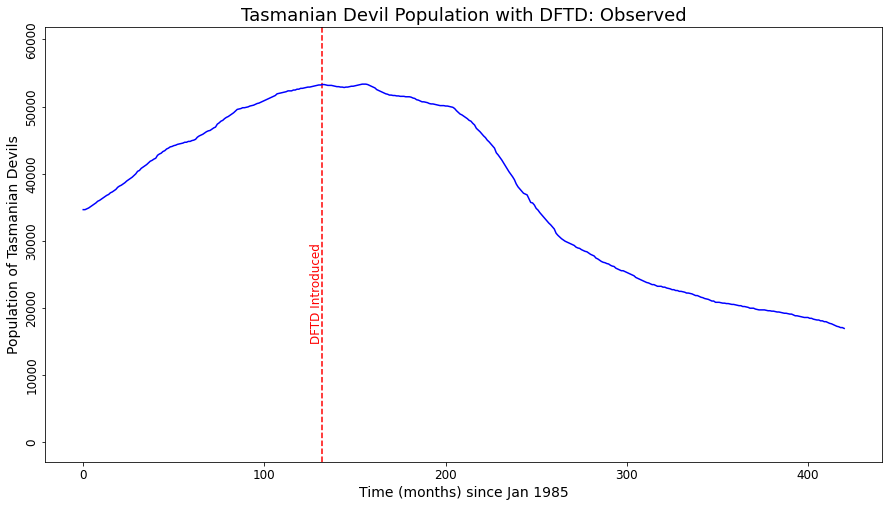

In [3]:
plt.figure(figsize=[15, 8])
plt.title("Tasmanian Devil Population with DFTD: Observed", fontsize=18)
plt.xlabel(f"Time (months) since {dates[0]}", fontsize=14)
plt.ylabel("Population of Tasmanian Devils", fontsize=14)
plt.plot([132, 132], [-3000, max(devil_pop)*1.16], '--r')
plt.ylim([-3000, max(devil_pop)*1.16])
plt.text(125, 15000, "DFTD Introduced", rotation="vertical", color="red", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation="vertical", va="center")
_ = plt.plot(range(len(devil_pop)), devil_pop, 'b', label='Observed Total')

## Model

In [4]:
variables = {
    "infected_concentration": 0.001,
    "r": "0.029",
    "ds": "0.0048",
    "dI": "0.044",
    "L": "27.39",
    "k0": "0.48"
}

In [5]:
class Devilsv101(Model):
    def __init__(self, values=None, events=None):
        Model.__init__(self, name="devils_v1.0")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="r", expression=values['r']))
        self.add_parameter(Parameter(name="K", expression=max(devil_pop)*1.16))
        self.add_parameter(Parameter(name="ds", expression=values['ds']))
        self.add_parameter(Parameter(name="dI", expression=values['dI']))
        self.add_parameter(Parameter(name="L", expression=values['L']))
        self.add_parameter(Parameter(name="k0", expression=values['k0']))

        # Variables (initial values adjusted to observed data)
        self.add_species(Species(name="S", initial_value=round(devil_pop[0]), mode="discrete"))
        self.add_species(Species(name="E", initial_value=0, mode="discrete"))
        self.add_species(Species(name="I", initial_value=0, mode="discrete"))
        self.add_species(Species(name="Devils", initial_value=round(devil_pop[0]), mode="discrete"))

        # Reactions
        self.add_reaction(Reaction(name="birth", reactants={}, products={'S': 1, 'Devils': 1}, propensity_function="r*(S+E+I)*(1-(S+E+I)/K)"))
        self.add_reaction(Reaction(name="death_S", reactants={'S': 1, 'Devils': 1}, products={}, propensity_function="ds*S"))
        self.add_reaction(Reaction(name="transmission", reactants={'S': 1, 'I': 1}, products={'E': 1, 'I':1}, propensity_function="k0*S*I/K"))
        self.add_reaction(Reaction(name="death_E", reactants={'Devils': 1, 'E': 1}, products={}, propensity_function="ds*E"))
        self.add_reaction(Reaction(name="latency", reactants={'E': 1}, products={'I': 1}, propensity_function="E/L"))
        self.add_reaction(Reaction(name="death_I", reactants={'I': 1, 'Devils': 1}, products={}, propensity_function="dI*I"))

        # Events
        if events is not None:
            self.add_event(events)
        
        # Timespan
        self.timespan(np.arange(0, 421, 1)) # month data tspan

In [6]:
def event_model(run=False):
    trigger = EventTrigger(expression="t >= 132")
    assignments = [
        EventAssignment(variable="I", expression=f"round(S * {variables['infected_concentration']})"),
        EventAssignment(variable="S", expression=f"round(S * 1-{variables['infected_concentration']})")
    ]
    dftd = Event(name="dftd", assignments=assignments, trigger=trigger)
    e_model = Devilsv101(values=variables, events=[dftd])
    
    if not run:
        return e_model
    
    results = e_model.run()

    plt.figure(figsize=[15, 8])
    plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
    plt.xlabel(f"Time (months) since {dates[0]}", fontsize=14)
    plt.ylabel("Population of Tasmanian Devils", fontsize=14)
    plt.plot(results['time'], obs[0][0], '--', c='black', label='Observed Total')
    plt.plot(results['time'], results['Devils'], 'b', label='Simulated Total')
    plt.plot(results['time'], results['S'], 'g', alpha=.3, label='Susceptible')
    plt.plot(results['time'], results['I'], 'r', alpha=.3, label='Infected')
    plt.plot(results['time'], results['E'], 'y', alpha=.3, label='Exposed')
    plt.plot([132, 132], [-3000, e_model.listOfParameters['K'].value], '--r')
    plt.ylim([-3000, e_model.listOfParameters['K'].value])
    plt.text(125, 15000, "DFTD Introduced", rotation="vertical", color="red", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation="vertical", va="center")
    plt.legend(loc='best', fontsize=12)

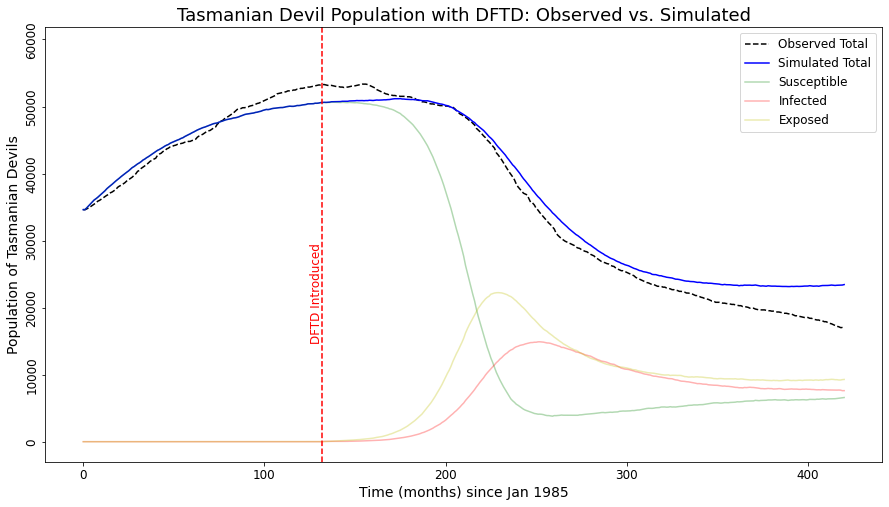

In [7]:
event_model(run=True)

In [8]:
model = Devilsv101(values=variables)

In [9]:
solver = SSACSolver(model, variable=True)

## Configure Solver Widgets

In [10]:
def run_pre_infection(start, end):
    variable = {
        "Devils": round(devil_pop[start]),
        "S": round(devil_pop[start]),
        "r": variables['r'],
        "ds": variables['ds']
    }
    results = solver.run(model=model, variables=variable, t=end-start)
    total_devils = np.add(np.add(results['I'], results['S']), results['E'])
    ks_result = stats.kstest(rvs=total_devils, cdf=devil_pop)
    return (results, total_devils, ks_result)

In [11]:
def run_post_infection(start, end, infected_concentration, pre_result):
    if start == 132:
        kwargs = {"t": end-start+len(pre_result['time']), "resume": pre_result}
        Devils_pop = pre_result['Devils'][-1]
        S_pop = round(Devils_pop * (1-infected_concentration))
        I_pop = round(Devils_pop * infected_concentration)
    else:
        kwargs = {"t": end-start}
        Devils_pop = round(devil_pop[start])
        S_pop = round(devil_pop[start] * (1-infected_concentration))
        I_pop = round(devil_pop[start] * infected_concentration)
    variable = {
        "Devils": Devils_pop,
        "S": S_pop,
        "I": I_pop,
        "r": variables['r'],
        "L": variables['L'],
        "k0": variables['k0'],
        "ds": variables['ds'],
        "dI": variables['dI']
    }
    results = solver.run(model=model, variables=variable, **kwargs)
    total_devils = np.add(np.add(results['I'], results['S']), results['E'])
    ks_result = stats.kstest(rvs=total_devils, cdf=devil_pop)
    return (results, total_devils, ks_result)

In [12]:
def display_details(infected_concentration, pre_start, pre_end, post_start, post_end, pre_data, post_data):
    print('='*100)
    print('|', 'Input Species:'.ljust(96), '|')
    print('|', f'\tInfected Concentration: {infected_concentration}'.ljust(91), '|')
    print(f'| {"-"*96} |')
    print('|', 'Input Parameters:'.ljust(96), '|')
    print('|', f'\tr: {variables["r"].ljust(29)}L: {variables["L"].ljust(29)}k0: {variables["k0"]}'.ljust(91), '|')
    print('|', f'\tds: {variables["ds"].ljust(28)}dI: {variables["dI"]}'.ljust(91), '|')
    print(f'|{"="*98}|')
    print('|', 'Pre-Infection'.ljust(46), end=' |')
    print('|', 'Post-Infection'.ljust(46), '|')
    print(f'| {"-"*46} || {"-"*46} |')
    print('|', f'Time Range: {dates[pre_start]} - {dates[pre_end]}'.ljust(46), end=' |')
    print('|', f'Time Range: {dates[post_start]} - {dates[post_end]}'.ljust(46), '|')
    print(f'| {"-"*46} || {"-"*46} |')
    print('|', f'Initial Value of Devils: {round(devil_pop[pre_start])}'.ljust(46), end=' |')
    print('|', f'Initial Value of Devils: {round(devil_pop[post_start])}'.ljust(46), '|')
    print('|', ' '*46, '||', f'Initial Value of S: {post_data[0]["S"][0]}'.ljust(46), '|')
    print('|', ' '*46, '||', f'Initial Value of I: {post_data[0]["I"][0]}'.ljust(46), '|')
    print(f'| {"-"*46} || {"-"*46} |')
    print('|', 'KS Test Results:'.ljust(46), '||', 'KS Test Results:'.ljust(46), '|')
    print('|', f'      Statistic: {pre_data[2].statistic}'.ljust(46), end=' |')
    print('|', f'      Statistic: {post_data[2].statistic}'.ljust(46), '|')
    print('|', f'      P Value: {pre_data[2].pvalue}'.ljust(46), end=' |')
    print('|', f'      P Value: {post_data[2].pvalue}'.ljust(46), '|')
    print('|', f'TOTAL Expected: {devil_pop[pre_end-1]} - Got: {pre_data[1][-1]}'.ljust(46), end=' |')
    print('|', f'TOTAL Expected: {devil_pop[post_end-1]} - Got: {post_data[1][-1]}'.ljust(46), '|')
    print('='*100)

In [13]:
def plot(pre_start, pre_end, post_start, post_end, pre_data, post_data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 6])
    
    ax1.plot(range(pre_start, pre_end), devil_pop[pre_start:pre_end], '--b', label='Observed Total')
    ax1.plot(range(pre_start, pre_end+1), pre_data[1], 'b', label='Simulated Total')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['S'], 'g', alpha=.3, label='Susceptible')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['I'], 'r', alpha=.3, label='Infected')
    ax1.plot(range(pre_start, pre_end+1), pre_data[0]['E'], 'y', alpha=.3, label='Exposed')
    ax1.set_xlabel(f"Time (months) since {dates[pre_start]}", fontsize=14)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=14)
    ax1.tick_params(axis="x", labelsize=12)
    ax1.tick_params(axis="y", labelsize=12, labelrotation=90)
    ax1.legend(loc='best')
    ax1.set_title(f'Tasmanian Devil Population: {dates[pre_start]}-{dates[pre_end]}', fontsize=14)
    
    if post_start > 132:
        x = range(post_start, post_end+1)
        obs_devils = devil_pop[post_start:post_end]
        sim_devils = post_data[1]
        S = post_data[0]['S']
        I = post_data[0]['I']
        E = post_data[0]['E']
    else:
        x = range(pre_end, post_end+1)
        obs_devils = devil_pop[pre_end:post_end]
        sim_devils = post_data[1][pre_end:post_end+1]
        S = post_data[0]['S'][pre_end:post_end+1]
        I = post_data[0]['I'][pre_end:post_end+1]
        E = post_data[0]['E'][pre_end:post_end+1]
    ax2.plot(x[:-1], obs_devils, '--b', label='Observed Total')
    ax2.plot(x, sim_devils, 'b', label='Simulated Total')
    ax2.plot(x, S, 'g', alpha=.3, label='Susceptible')
    ax2.plot(x, I, 'r', alpha=.3, label='Infected')
    ax2.plot(x, E, 'y', alpha=.3, label='Exposed')
    ax2.set_xlabel(f"Time (months) since {dates[post_start]}", fontsize=14)
    ax2.set_ylabel("Population of Tasmanian Devils", fontsize=14)
    ax2.tick_params(axis="x", labelsize=12)
    ax2.tick_params(axis="y", labelsize=12, labelrotation=90)
    ax2.legend(loc='best')
    ax2.set_title(f'Tasmanian Devil Population with DFTD: {dates[post_start]}-{dates[post_end]}', fontsize=14)

In [14]:
def configure(start, end, infected_concentration, birth, L, k0, S_death, I_death):
    pre_start = 0 if start >= 132 else start
    pre_end = 132 if end > 132 else end
    post_start = 132 if start < 132 else start
    post_end = 421 if end <= 132 else end

    run_pre = False
    try:
        pre_data
        if start < 132:
            if (pre_end - pre_start) != len(pre_data[0]['time']):
                run_pre = True
            else:
                run_pre = variables['r'] != birth or variables['ds'] != S_death
    except:
        run_pre = True
        
    try:
        post_data
        run_post = end > 132
    except:
        run_post = True
    
    variables['infected_concentration'] = infected_concentration
    variables['r'] = str(birth)
    variables['ds'] = str(S_death)
    variables['L'] = str(L)
    variables['k0'] = str(k0)
    variables['dI'] = str(I_death)
    
    if run_pre:
        pre_data = run_pre_infection(pre_start, pre_end)
        
    if run_post:
        post_data = run_post_infection(post_start, post_end, infected_concentration, pre_data[0])
    
    display_details(infected_concentration, pre_start, pre_end, post_start, post_end, pre_data, post_data)
    
    plot(pre_start, pre_end, post_start, post_end, pre_data, post_data)

## Create Widgets

In [15]:
ai_widgets = {
    "start": widgets.IntSlider(min=0, max=420, step=1, value=0),
    "end": widgets.IntSlider(min=1, max=421, step=1, value=421),
    "infected_concentration": widgets.FloatSlider(min=0.001, max=1, step=0.001, value=0.001),
    "birth": widgets.FloatSlider(min=0, max=.08333, step=0.001, value=variables['r']),
    "L": widgets.FloatSlider(min=0, max=100, step=0.01, value=variables['L']),
    "k0": widgets.FloatSlider(min=0, max=2, step=0.01, value=variables['k0']),
    "S_death": widgets.FloatSlider(min=0.0028, max=.0074, step=.0001, value=variables['ds']),
    "I_death": widgets.FloatSlider(min=0, max=.1, step=.001, value=variables['dI'])
}
ui = widgets.HBox(list(ai_widgets.values()))

## Run widgets and attempt to calibrate model

In [16]:
out = interactive(configure, **ai_widgets)
display(out)

interactive(children=(IntSlider(value=0, description='start', max=420), IntSlider(value=421, description='end'…

## Run calibrated event model

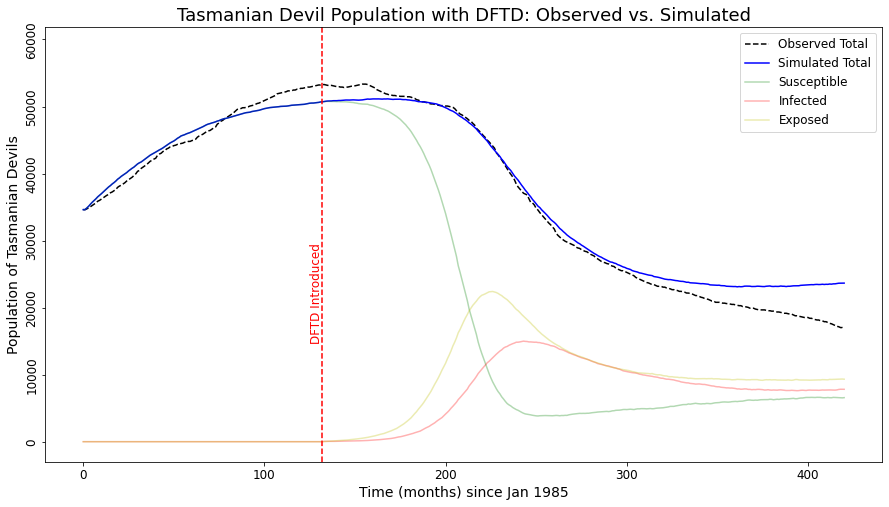

In [17]:
event_model(run=True)

## Export model as StochSS Model (.mdl)

In [18]:
stochss_mdl = export_StochSS(event_model(), filename="Devil_Pre-Vaccination", return_stochss_model=True)
class NumpyEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, np.ndarray):
            return o.tolist()
        if isinstance(o, np.int64):
            return int(o)
        return json.JSONEncoder.default(self, o)
with open("Devil_Pre-Vaccination.mdl", "w") as mdl_file:
    json.dump(stochss_mdl, mdl_file, indent=4, sort_keys=True, cls=NumpyEncoder)